In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

In [3]:
!pwd

/root/Internship-Valeo/Project


In [4]:
DATA_PATH = '/root/Internship-Valeo/Project/data'
TMPDIR = '/root/Internship-Valeo/Project/tmp'

In [5]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points)
from models.utils import shared_encoder, detector_head, detector_loss, model_metrics, box_nms
from utils.tools import dict_update

In [6]:
default_config = {
            'primitives': 'all',
            'truncate': {},
            'validation_size': -1,
            'test_size': -1,
            'on-the-fly': False,
            'cache_in_memory': False,
            'suffix': None,
            'add_augmentation_to_test_set': False,
            'num_parallel_calls': 10,
            'generation': {
                'split_sizes': {'training': 10000, 'validation': 200, 'test': 500},
                'image_size': [960, 1280],
                'random_seed': 0,
                'params': {
                    'generate_background': {
                        'min_kernel_size': 150, 'max_kernel_size': 500,
                        'min_rad_ratio': 0.02, 'max_rad_ratio': 0.031},
                    'draw_stripes': {'transform_params': (0.1, 0.1)},
                    'draw_multiple_polygons': {'kernel_boundaries': (50, 100)}
                },
            },
            'preprocessing': {
                'resize': [240, 320],
                'blur_size': 11,
            },
            'augmentation': {
                'photometric': {
                    'enable': False,
                    'primitives': 'all',
                    'params': {},
                    'random_order': True,
                },
                'homographic': {
                    'enable': False,
                    'params': {},
                    'valid_border_margin': 0,
                },
            }
    }
drawing_primitives = [
            'draw_lines',
            'draw_polygon',
            'draw_multiple_polygons',
            'draw_ellipses',
            'draw_star',
            'draw_checkerboard',
            'draw_stripes',
            'draw_cube',
            'gaussian_noise'
    ]

In [7]:
import yaml
with open('/root/Internship-Valeo/Project/configs/magic-point_shapes.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [8]:
config1 = config
config = dict_update(default_config, config['data'])

In [9]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [10]:
# no need to run this again as synthetic shapes have been generated

def dump_primitive_data(primitive, tar_path, config):
    temp_dir = Path(TMPDIR, primitive)

    synthetic_dataset.set_random_state(np.random.RandomState(
                config['generation']['random_seed']))
    for split, size in config['generation']['split_sizes'].items():
        im_dir, pts_dir = [Path(temp_dir, i, split) for i in ['images', 'points']]
        im_dir.mkdir(parents=True, exist_ok=True)
        pts_dir.mkdir(parents=True, exist_ok=True)

        for i in tqdm(range(size), desc=split, leave=False):
            image = synthetic_dataset.generate_background(
                        config['generation']['image_size'],
                        **config['generation']['params']['generate_background'])
            points = np.array(getattr(synthetic_dataset, primitive)(
                        image, **config['generation']['params'].get(primitive, {})))
            points = np.flip(points, 1)  # reverse convention with opencv

            b = config['preprocessing']['blur_size']
            image = cv2.GaussianBlur(image, (b, b), 0)
            points = (points * np.array(config['preprocessing']['resize'], np.float)
                          / np.array(config['generation']['image_size'], np.float))
            image = cv2.resize(image, tuple(config['preprocessing']['resize'][::-1]),
                                   interpolation=cv2.INTER_LINEAR)

            cv2.imwrite(str(Path(im_dir, '{}.png'.format(i))), image)
            np.save(Path(pts_dir, '{}.npy'.format(i)), points)

    # Pack into a tar file
    tar = tarfile.open(tar_path, mode='w:gz')
    tar.add(temp_dir, arcname=primitive)
    tar.close()
    shutil.rmtree(temp_dir)

In [11]:
primitives = parse_primitives(config['primitives'], drawing_primitives)
basepath = Path(
                DATA_PATH, 'synthetic_shapes' +
                ('_{}'.format(config['suffix']) if config['suffix'] is not None else ''))
basepath.mkdir(parents=True, exist_ok=True)

splits = {s: {'images': [], 'points': []}
                  for s in ['training', 'validation', 'test']}

In [12]:
# no need to run this again as synthetic shapes have been generated

for primitive in primitives:
    tar_path = Path(basepath, '{}.tar.gz'.format(primitive))
    if not tar_path.exists():
        dump_primitive_data(primitive, tar_path, config)

In [13]:
for primitive in primitives:
    # Untar locally
    tar_path = Path(basepath, '{}.tar.gz'.format(primitive))
    tar = tarfile.open(tar_path)
    temp_dir = Path(TMPDIR)
    tar.extractall(path=temp_dir)
    tar.close()
    # Gather filenames in all splits, optionally truncate
    truncate = config['truncate'].get(primitive, 1)
    path = Path(temp_dir, primitive)
    for s in splits:
        e = [str(p) for p in Path(path, 'images', s).iterdir()]
        f = [p.replace('images', 'points') for p in e]
        f = [p.replace('.png', '.npy') for p in f]
        splits[s]['images'].extend(e[:int(truncate*len(e))])
        splits[s]['points'].extend(f[:int(truncate*len(f))])

In [14]:
# Shuffle
for s in splits:
    perm = np.random.RandomState(0).permutation(len(splits[s]['images']))
    for obj in ['images', 'points']:
        splits[s][obj] = np.array(splits[s][obj])[perm].tolist()

In [15]:
len(splits['training']['images']), len(splits['test']['images']), len(splits['validation']['images'])

(66000, 3300, 1320)

In [16]:
# code for photometric augmentation

primitives_photo = parse_primitives(config['primitives'], photaug.augmentations)

prim_configs = [config['augmentation']['photometric']['params'].get(p, {}) for p in primitives_photo]

indices = tf.range(len(primitives_photo))
if config['augmentation']['photometric']['random_order']:
    indices = tf.random.shuffle(indices)
def photo_aug_step(i, image):
    fn_pairs = [(tf.equal(indices[i], j), lambda p=p, c=c: getattr(photaug, p)(image, **c))
                for j, (p, c) in enumerate(zip(primitives_photo, prim_configs))]
    image = tf.case(fn_pairs)
    return i + 1, image

In [17]:
def _gen_shape():
    primitives = parse_primitives(config['primitives'], drawing_primitives)
    while True:
        primitive = np.random.choice(primitives)
        image = synthetic_dataset.generate_background(
                        config['generation']['image_size'],
                        **config['generation']['params']['generate_background'])
        points = np.array(getattr(synthetic_dataset, primitive)(
                        image, **config['generation']['params'].get(primitive, {})))
        yield (np.expand_dims(image, axis=-1).astype(np.float32),
                       np.flip(points.astype(np.float32), 1))

In [18]:
def _read_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=1)
    return tf.cast(image, tf.float32)

In [19]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [20]:
if config['on-the-fly']:
    data = tf.data.Dataset.from_generator(
                    _gen_shape, (tf.float32, tf.float32),
                    (tf.TensorShape(config['generation']['image_size']+[1]),
                     tf.TensorShape([None, 2])))
    data = data.map(lambda i, c: pipeline.downsample(
                    i, c, **config['preprocessing']))
else:
    # Initialize dataset with file names
    data = tf.data.Dataset.from_tensor_slices(
                    (splits['training']['images'], splits['training']['points']))
    # Read image and point coordinates
    data = data.map(
                    lambda image, points:
                    (_read_image(image), tf.numpy_function(_read_points, [points], tf.float32)))
    data = data.map(lambda image, points: (image, tf.reshape(points, [-1, 2])))

# if split_name == 'validation':
#     data = data.take(config['validation_size'])
# elif split_name == 'test':
#     data = data.take(config['test_size'])

data = data.map(lambda image, kp: {'image': image, 'keypoints': kp})
data = data.map(pipeline.add_dummy_valid_mask)

In [21]:
if config['augmentation']['photometric']['enable']:
    data = data.map(lambda d: pipeline.photometric_augmentation(d, **config['augmentation']['photometric']))
if config['augmentation']['homographic']['enable']:
    data = data.map(lambda d: pipeline.homographic_augmentation(
                    d, **config['augmentation']['homographic']))

# Convert the point coordinates to a dense keypoint map
data = data.map(pipeline.add_keypoint_map)
data = data.map(lambda d: {**d, 'image': tf.cast(d['image'], tf.float32) / 255.})

In [22]:
if config['on-the-fly']:
    val_data = tf.data.Dataset.from_generator(
                    _gen_shape, (tf.float32, tf.float32),
                    (tf.TensorShape(config['generation']['image_size']+[1]),
                     tf.TensorShape([None, 2])))
    val_data = val_data.map(lambda i, c: pipeline.downsample(
                    i, c, **config['preprocessing']))
else:
    # Initialize dataset with file names
    val_data = tf.data.Dataset.from_tensor_slices(
                    (splits['validation']['images'], splits['validation']['points']))
    # Read image and point coordinates
    val_data = val_data.map(
                    lambda image, points:
                    (_read_image(image), tf.numpy_function(_read_points, [points], tf.float32)))
    val_data = val_data.map(lambda image, points: (image, tf.reshape(points, [-1, 2])))

val_data = val_data.map(lambda image, kp: {'image': image, 'keypoints': kp})
val_data = val_data.map(pipeline.add_dummy_valid_mask)

# Convert the point coordinates to a dense keypoint map
val_data = val_data.map(pipeline.add_keypoint_map)
val_data = val_data.map(lambda d: {**d, 'image': tf.cast(d['image'], tf.float32) / 255.})

In [23]:
default_model_config = {
            'data_format': 'channels_first',
            'kernel_reg': 0.,
            'grid_size': 8,
            'detection_threshold': 0.4,
            'homography_adaptation': {'num': 0},
            'nms': 0,
            'top_k': 0
    }

In [24]:
model_config = dict_update(default_model_config, config1['model'])

In [25]:
# class SyntheticShapes(keras.utils.Sequence):
#     def __init__(self, image_files, point_files, is_training, batch_size = model_config['batch_size']):
#         self.__image_files, self.__point_files = image_files, point_files
#         self.__batch_size = batch_size
#         self.__is_training = is_training
#     def __getitem__(self, index):
#         images = []
#         points_maps = []
#         points_list = []
#         homography_list = [] # not returned yet
#         warped_images = []
#         valid_masks = []
#         warped_points_list = []
#         warped_points_maps = []
        
        
#         if (index + 1)*self.__batch_size > len(self.__image_files):
#             self.__batch_size = len(self.__image_files) - index * self.__batch_size
            
#         batch_img_files = self.__image_files[index * self.__batch_size:(index + 1) * self.__batch_size]
#         batch_point_files = self.__point_files[index * self.__batch_size:(index + 1) * self.__batch_size]
        
#         for img_file, point_file, itr in zip(batch_img_files, batch_point_files, range(self.__batch_size)):

#             image = cv2.imread(img_file, 0)
#             image = np.expand_dims(image, axis = 2)
#             image_shape = tf.shape(image)[:2]
#             points = _read_points(point_file)
#             points = np.round(points).astype(int)
            
#             if self.__is_training:
#                 # add photometric_augmentation
#                 _, image = tf.while_loop(lambda i, image: tf.less(i, len(primitives_photo)),
#                                  photo_aug_step, [0, image], parallel_iterations=1)              
                
#                 # add homography
#                 homography = sample_homography(image_shape, config['augmentation']['homographic']['params'])[0]
#                 warped_image = H_transform(image, homography, interpolation='BILINEAR')
#                 valid_mask = compute_valid_mask(image_shape, homography,
#                                          config['augmentation']['homographic']['params']['valid_border_margin'])
#                 warped_points = warp_points(points, homography)
#                 warped_points = filter_points(warped_points, image_shape)
#                 warped_points = np.round(warped_points).astype(int)
                
#                 warped_kp = tf.minimum(warped_points, image_shape-1)
#                 warped_points_map = tf.scatter_nd(warped_kp, tf.ones([tf.shape(warped_kp)[0]], 
#                                                                      dtype=tf.int32), image_shape)
                        
#                 homography_list.append(homography)
#                 warped_image = warped_image / 255.0
#                 warped_images.append(warped_image)
#                 valid_masks.append(valid_mask)
#                 warped_points_list.append(warped_points)
#                 warped_points_maps.append(warped_points_map)

#             kp = tf.minimum(points, image_shape-1)
#             points_map = tf.scatter_nd(kp, tf.ones([tf.shape(kp)[0]], dtype=tf.int32), image_shape)
            
#             image = image / 255.0
#             images.append(image)
#             points_maps.append(points_map)
#             points_list.append(points)
            
            
#         images = np.array(images)
#         points_maps = np.expand_dims(points_maps, axis = 3)
        
#         if self.__is_training:
#             warped_images = np.array(warped_images)
#             warped_points_maps = np.expand_dims(warped_points_maps, axis = 3)
#             valid_masks = np.array(valid_masks)
#             dummy_loss_target = np.zeros(self.__batch_size)

#             return [warped_images, valid_masks, warped_points_maps], [dummy_loss_target]
        
#         else:
#             return images, points_maps   
           
#     def __len__(self):
#         return int(np.ceil(len(self.__image_files) / float(self.__batch_size)))
    
#     def on_epoch_end(self):
#         pass

In [26]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1]['logits'], model_config = model_config, valid_mask = inputs[2])
        
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
#         self.add_loss(tf.math.reduce_mean(loss))
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'precision')
        self.add_metric(metrics['recall'], name = 'recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

def net(input_shape1, input_shape2, input_shape3):
    images_inputs = Input(shape = input_shape1, name = 'image')
    valid_masks_inputs = Input(shape = input_shape2, name = 'valid_mask')
    warped_points_inputs = Input(shape = input_shape3, name = 'keypoints')
    
    if model_config['data_format'] == 'channels_first':
        images_inputs1 = tf.transpose(images_inputs, [0, 3, 1, 2])
    
    encoder = shared_encoder(shape = (1, 120, 160), model_config = model_config)
    encoder_output = encoder(images_inputs1)
    
    detector = detector_head(shape= (128, 15, 20), model_config = model_config)
    output = detector(encoder_output)
        
    loss_layer = DetectorLossLayer()([warped_points_inputs, output, valid_masks_inputs])
    
    model = keras.models.Model(inputs = [images_inputs, valid_masks_inputs, warped_points_inputs] , 
                               outputs = [loss_layer])
    return model

In [27]:
model = net(input_shape1 = (120, 160, 1), input_shape2 = (120, 160), input_shape3 = (120, 160))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


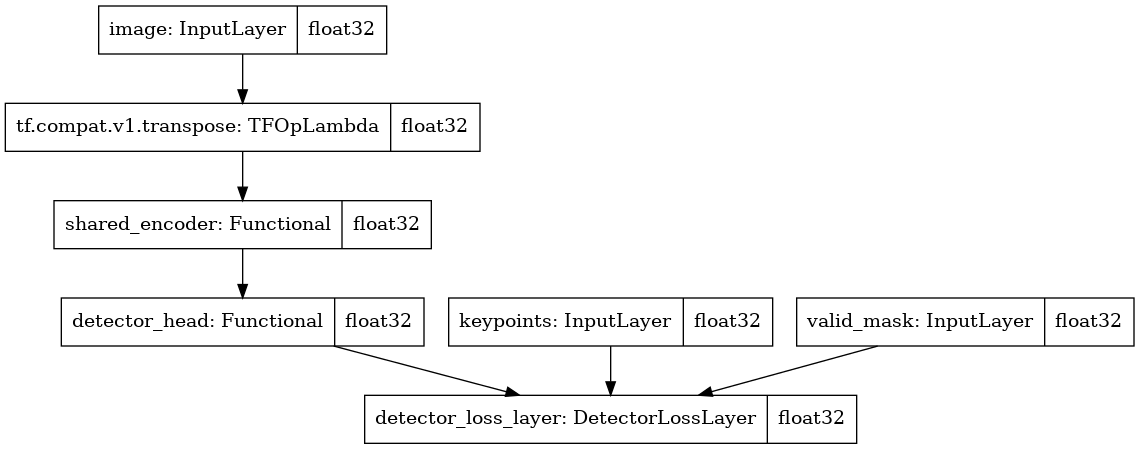

In [32]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=False, show_dtype=True, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [33]:
def dummy_loss(dummy_target, y_pred):
#     return tf.squeeze(y_pred)
    return y_pred

model.compile(optimizer = keras.optimizers.Adam(learning_rate = model_config['learning_rate']),
              loss = dummy_loss)

In [ ]:
# batch_size = model_config['batch_size']

# train_gen = SyntheticShapes(splits['training']['images'], splits['training']['points'], 
#                                            batch_size = batch_size, is_training = True)

# val_gen = SyntheticShapes(splits['validation']['images'], splits['validation']['points'], 
#                                          batch_size = batch_size, is_training = True)

# train_steps =  len(splits['training']['images'])/batch_size

In [34]:
data = data.repeat()
data = data.batch(model_config['batch_size'])

In [35]:
val_data

<MapDataset shapes: {image: (None, None, 1), keypoints: (None, None), valid_mask: (None, None)}, types: {image: tf.float32, keypoints: tf.int32, valid_mask: tf.int32}>

In [36]:
val_data = val_data.take(config['validation_size'])
val_data = val_data.batch(model_config['eval_batch_size'])

In [ ]:
steps_per_epoch = len(splits['training']['images'])//model_config['batch_size']
epochs = config1['train_iter']//steps_per_epoch
history = model.fit(data , validation_data = val_data, batch_size = model_config['batch_size'], 
                     steps_per_epoch = steps_per_epoch, epochs=epochs, 
                    callbacks=[tensorboard_callback])

Epoch 1/48
 197/1031 [====>.........................] - ETA: 17:13 - loss: 2.9133 - precision: 5.9883e-04 - recall: 0.0538

In [ ]:
# model.save('/root/Internship-Valeo/Project/results/checkpoint-magicpoint-120x160-synth-no_aug-150322')

In [ ]:
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-magicpoint-no_aug')

In [ ]:
x, y = train_gen.__getitem__(0)

In [37]:
x, y = data.take(2)

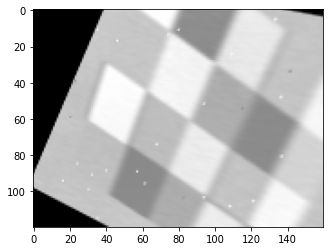

In [38]:
plt.imshow(x['image'][0], cmap = 'gray')

In [39]:
x['image'].shape

TensorShape([64, 120, 160, 1])

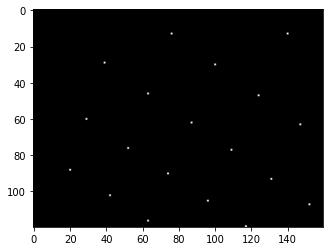

In [40]:
plt.imshow(x['keypoints'][0], cmap = 'gray')

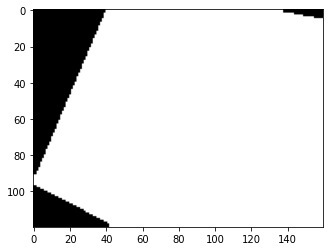

In [41]:
plt.imshow(x['valid_mask'][0], cmap = 'gray')

In [42]:
x['keypoints'][0]

<tf.Tensor: shape=(120, 160), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [43]:
model_metrics(np.array(x['keypoints'][0]), np.array(x['keypoints'][0]), np.array(x['valid_mask'][0]))

{'precision': <tf.Tensor: shape=(), dtype=float64, numpy=1.0>,
 'recall': <tf.Tensor: shape=(), dtype=float64, numpy=1.0>}

In [ ]:
plt.imshow(x[0][0], cmap = 'gray')

In [ ]:
plt.imshow(x[2][0],cmap = 'gray')

In [ ]:
test_gen = SyntheticShapes(splits['test']['images'], splits['test']['points'], 
                           batch_size = model_config['batch_size'], is_training = True)

In [ ]:
x, y = test_gen.__getitem__(1)

In [ ]:
plt.imshow(x[0][0], cmap = 'gray')

In [ ]:
plt.imshow(x[1][0], cmap = 'gray')

In [ ]:
plt.imshow(x[2][0],cmap = 'gray')

In [ ]:
result = model(x)

In [ ]:
tf.math.reduce_mean(result)

In [ ]:
prob = model.get_layer('tf.compat.v1.squeeze').output
m = keras.models.Model(inputs = model.input, outputs = prob)

y_pred = m.predict(x)

if model_config['nms']:
    prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred)
    pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
    
# pred = pred * x[1] # multiplied with valid masks

plt.imshow(pred[0], cmap = 'gray')